# Library Import and Functions

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import re


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
name: extract_transcript_id

input: GTF attribute column

output: transcript_id for each entry

purpose: Creating a transcript_id columns from attributes column in GTF
'''


def extract_transcript_id(attributes):
    match = re.search('transcript_id "([^"]+)', attributes)
    return match.group(1) if match else None

In [3]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    df_sums = df[["gene_id", "total_CPM"]].groupby("gene_id").sum()
    
    df_sums["total_CPM_gene"] = df_sums["total_CPM"]

    df_sums.drop(columns="total_CPM", inplace=True)
    
    merged_df = pd.merge(df, df_sums, how='inner', on="gene_id")
    
    merged_df["relative_abundance_percent"] = ((merged_df["total_CPM"]/merged_df["total_CPM_gene"]) * 100)
    
    merged_df["total_CPM_transcript"] = merged_df["total_CPM"]
    
    merged_df.drop(columns="total_CPM", inplace=True)


    return merged_df

In [4]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [5]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [6]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df  

### Import 2023 reference and disease gene lists

In [7]:
## Open original reference
ref_2023 = pd.read_csv("../references/Homo_sapiens.GRCh38.109.gtf", header=None, delimiter="\t", low_memory=False, 
                       names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"], comment="#")

ref_2023 = ref_2023.loc[~ref_2023["chr"].str.startswith("ERCC-")]

## Parse through reference to get gene names and ids
gene_ref_2023 = ref_2023.loc[ref_2023["type"]=="gene"].copy()
gene_ref_2023 = parse_df_columns(gene_ref_2023, is_ref=True)

## Create 2023 transcript ref
transcript_ref_2023 = ref_2023.loc[ref_2023["type"]=="transcript"].copy()
transcript_ref_2023 = parse_df_columns(transcript_ref_2023, is_ref=True, is_transcript=True)

## Import disease relevant genes
disease_relevant_genes = pd.read_csv("../references/medically_relevant_genes.tsv", sep="\t")

## Brain disease genes
brain_disease_gene_ids = pd.read_csv("../references/brain_disease_genes_only_IDs.tsv", sep="\t")
brain_disease_annotations = pd.read_csv("../references/brain_disease_genes_with_disease.tsv", sep="\t")


## Create disease relevant list including chromosome
disease_relevant_genes_annotated = disease_relevant_genes.merge(gene_ref_2023[["gene_id", "gene_name", "chr"]], 
                                                               how="inner", on=["gene_id", "gene_name"])

## Create list of protein coding genes
protein_coding_ref_2023 = gene_ref_2023.loc[gene_ref_2023["gene_biotype"] == "protein_coding"].copy()

In [10]:
## Get Alzheimer's risk gene ids
ad_gene_ids = brain_disease_annotations.loc[brain_disease_annotations["disease"] == "AD"]["gene_id"].copy()

In [11]:
## Only keep transcripts from AD risk genes
transcript_ref_2023_ad = transcript_ref_2023.loc[transcript_ref_2023["gene_id"].isin(ad_gene_ids)].copy()

In [12]:
## Average number of transcripts per AD risk gene
transcripts_per_ad_risk_gene = (transcript_ref_2023_ad["transcript_id"].nunique()/transcript_ref_2023_ad["gene_id"].nunique())

In [14]:
## Parse through 2023 GTF 109 Ensembl reference to get transcript biotypes
ref_2023_types = ref_2023.loc[ref_2023["type"]=="transcript"].copy()
ref_2023_types = parse_df_columns(ref_2023_types, is_ref=True, is_transcript=True)

## Make reference only including protein coding transcripts with a defined CDS
ref_2023_cds = ref_2023.loc[ref_2023["type"]=="CDS"].copy()
ref_2023_cds = parse_df_columns(ref_2023_cds, is_ref=True, is_transcript=True, is_prot=True)

ref_2023_cds = ref_2023_cds.loc[ref_2023_cds["transcript_biotype"] == "protein_coding"].copy()

## Create unique identifier for protein id based on individual CDS entries for the protein

## Create datagrame for unique protein id 
unique_protein_id = pd.DataFrame()

## Create a reference with columns as strings instead of integers so they can be concatenated
string_ref_2023_cds = ref_2023_cds[['protein_id', 'start', 'end', "chr", "strand"]].copy().astype(str)

## Join the coordinates for all CDS based on protein id to create a unique identifier
unique_protein_id = string_ref_2023_cds.groupby(['protein_id'])[["protein_id", "chr", "strand",
                                                                 "start", "end"]].transform(lambda x: '-'.join(x))

## Add protein id column
unique_protein_id["protein_id"] = unique_protein_id["protein_id"].str.split("-", expand=True)[0]

## Add unique identifier column
unique_protein_id["unique_identifier"] = "Chromosome: " + unique_protein_id["chr"].str.split("-", expand=True)[0] + "\n" \
                                            + "Strand: " + unique_protein_id["strand"].str.split("-", expand=True)[0] + "\n" \
                                            + "Start coordinates: " + unique_protein_id["start"].copy() \
                                            + "End coordinates:" + unique_protein_id["end"].copy()

## Drop all columns besided protein id and unique identifier
unique_protein_id = unique_protein_id[["protein_id", "unique_identifier"]].copy()

## Drop any duplicates
unique_protein_id.drop_duplicates(inplace=True)

## Get transcript_id column back by merging on index with ref_2023_cds
unique_protein_id = unique_protein_id.merge(ref_2023_cds["transcript_id"], left_index=True, right_index=True)

## Merge back to ref_2023_cds on protein_id and transcript id to so we can add unique identifier
ref_2023_cds = ref_2023_cds.merge(unique_protein_id, on=["protein_id", "transcript_id"], how="inner")

## Make protein coding ID into unique identifier
ref_2023_cds["protein_id"] = ref_2023_cds["unique_identifier"].copy()
ref_2023_cds.drop(columns="unique_identifier", inplace=True)

## Create final CDS reference only containing non NA valued for protein id
ref_cds = ref_2023_cds.loc[~ref_2023_cds["protein_id"].isna()].copy()

## Only keep transcript id and unique protein id in the ref_cds final reference
ref_cds = ref_cds[["transcript_id", "protein_id"]].copy().drop_duplicates()

In [16]:
## Get protein coding AD transcripts and their unique protein ids
ref_cds_ad = ref_cds.loc[ref_cds["transcript_id"].isin(transcript_ref_2023_ad["transcript_id"])].copy()

In [18]:
print((ref_cds_ad["protein_id"].nunique()/transcript_ref_2023_ad["gene_id"].nunique()))

5.135135135135135


## Create reference for protein coding sequences

In [26]:
## Parse through 2023 GTF 109 Ensembl reference to get transcript biotypes
ref_2023_types = ref_2023.loc[ref_2023["type"]=="transcript"].copy()
ref_2023_types = parse_df_columns(ref_2023_types, is_ref=True, is_transcript=True)

## Make reference only including protein coding transcripts with a defined CDS
ref_2023_cds = ref_2023.loc[ref_2023["type"]=="CDS"].copy()
ref_2023_cds = parse_df_columns(ref_2023_cds, is_ref=True, is_transcript=True, is_prot=True)

ref_2023_cds = ref_2023_cds.loc[ref_2023_cds["transcript_biotype"] == "protein_coding"].copy()

## Create unique identifier for protein id based on individual CDS entries for the protein

## Create datagrame for unique protein id 
unique_protein_id = pd.DataFrame()

## Create a reference with columns as strings instead of integers so they can be concatenated
string_ref_2023_cds = ref_2023_cds[['protein_id', 'start', 'end', "chr", "strand"]].copy().astype(str)

## Join the coordinates for all CDS based on protein id to create a unique identifier
unique_protein_id = string_ref_2023_cds.groupby(['protein_id'])[["protein_id", "chr", "strand",
                                                                 "start", "end"]].transform(lambda x: '-'.join(x))

## Add protein id column
unique_protein_id["protein_id"] = unique_protein_id["protein_id"].str.split("-", expand=True)[0]

## Add unique identifier column
unique_protein_id["unique_identifier"] = "Chromosome: " + unique_protein_id["chr"].str.split("-", expand=True)[0] + "\n" \
                                            + "Strand: " + unique_protein_id["strand"].str.split("-", expand=True)[0] + "\n" \
                                            + "Start coordinates: " + unique_protein_id["start"].copy() \
                                            + "End coordinates:" + unique_protein_id["end"].copy()

## Drop all columns besided protein id and unique identifier
unique_protein_id = unique_protein_id[["protein_id", "unique_identifier"]].copy()

## Drop any duplicates
unique_protein_id.drop_duplicates(inplace=True)

## Get transcript_id column back by merging on index with ref_2023_cds
unique_protein_id = unique_protein_id.merge(ref_2023_cds["transcript_id"], left_index=True, right_index=True)

## Merge back to ref_2023_cds on protein_id and transcript id to so we can add unique identifier
ref_2023_cds = ref_2023_cds.merge(unique_protein_id, on=["protein_id", "transcript_id"], how="inner")

## Make protein coding ID into unique identifier
ref_2023_cds["protein_id"] = ref_2023_cds["unique_identifier"].copy()
ref_2023_cds.drop(columns="unique_identifier", inplace=True)

## Create final CDS reference only containing non NA valued for protein id
ref_cds = ref_2023_cds.loc[~ref_2023_cds["protein_id"].isna()].copy()

## Only keep transcript id and unique protein id in the ref_cds final reference
ref_cds = ref_cds[["transcript_id", "protein_id"]].copy().drop_duplicates()

In [27]:
## Output references with transcripts_id and unique protein_id as a tsv to the processed data folder

ref_cds.to_csv("../data/processed/transcript_id_and_unique_protein_id_reference.tsv", sep="\t", index=False)

## Load transcript counts matrix and CPM normalize it

In [28]:
## Load matrix
df = pd.read_csv("../data/raw/counts_transcript.txt", sep="\t")

## Fix columns names
df = fix_column_names(df.copy(), is_gene=False)

## Add total counts column
df["total_counts"] = df[df.filter(regex='count').columns].copy().sum(axis=1)

## CPM normalize counts matrix
df = calculate_cpm(df.copy(), is_gene=False)

## Create median CPM column
df["median_CPM"] = df[df.filter(regex='CPM').columns].copy().median(axis=1)

## Drop counts columns and save dataframe
df.drop(columns=df.filter(regex='count').columns, inplace=True)
df.to_csv("../data/processed/cpm_transcript.txt", sep="\t", index=False)

## Make figures looking at brain level expression of new isoforms since 2019

In [29]:
## Only keep transcripts that are exclusive to the 2023 annotation when compared to 2019
exclusive_2023_transcripts = transcript_ref_2023.loc[~transcript_ref_2023["transcript_id"].isin(transcript_ref_2019_ids)].copy()

In [30]:
## Create list of new CCDS since 2019

## Get all transcript IDs from ENSEMBL 96 GTF (2019)
cds_2019_ref = transcript_ref_2019.merge(ref_cds, how="inner", on="transcript_id").dropna(subset="protein_id")
cds_2019_ref_protein_ids = cds_2019_ref["protein_id"].copy()

## Get transcript names from ENSEMBL 109 GTF (2023)
cds_2023_ref = transcript_ref_2023.merge(ref_cds, how="inner", on="transcript_id").dropna(subset="protein_id")

## Get ensmbl 109 (2023) exclusive protein coding sequences
exclusive_2023_cds = cds_2023_ref.loc[~cds_2023_ref["transcript_id"].isin(transcript_ref_2019_ids)].copy()
exclusive_2023_cds = exclusive_2023_cds.loc[~exclusive_2023_cds["protein_id"].isin(cds_2019_ref_protein_ids)].copy()

In [31]:
## Create counts matrix only including the new transcripts found after ENSEMBL 94

df_exclusive_2023_transcripts = df.loc[df["transcript_id"].isin(exclusive_2023_transcripts["transcript_id"])].copy()
df_exclusive_2023_ccds = df.loc[df["transcript_id"].isin(exclusive_2023_cds["transcript_id"])].copy()

In [32]:
## Create lists with numbers of 2023 exclusive transcripts expressed across CPM thresholds

list_cpm_thresh = []

list_2023_all_transcript_median = []
list_2023_new_cds_transcript_median = []
list_2023_med_relevant_transcript_median = []
list_2023_med_relevant_new_cds_transcript_median = []
list_2023_brain_relevant_transcript_median = []
list_2023_brain_relevant_new_cds_transcript_median = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    
    median_2023 = df_exclusive_2023_transcripts.loc[df_exclusive_2023_transcripts["median_CPM"] >= cpm_thresh].copy()
    new_cds_median_2023 = df_exclusive_2023_ccds.loc[df_exclusive_2023_ccds["median_CPM"] >= cpm_thresh].copy()
    med_relevant_median_2023 = median_2023.loc[median_2023["gene_id"].isin(disease_relevant_genes["gene_id"])].copy()
    med_relevant_new_cds_median_2023 = med_relevant_median_2023.loc[med_relevant_median_2023["transcript_id"].isin(new_cds_median_2023["transcript_id"])].copy()
    brain_relevant_median_2023 = median_2023.loc[median_2023["gene_id"].isin(brain_disease_gene_ids["gene_id"])].copy()
    brain_relevant_new_cds_median_2023 = brain_relevant_median_2023.loc[brain_relevant_median_2023["transcript_id"].isin(new_cds_median_2023["transcript_id"])].copy()
    
    
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_2023_all_transcript_median.append(median_2023.shape[0])
    list_2023_new_cds_transcript_median.append(new_cds_median_2023.shape[0])
    list_2023_med_relevant_transcript_median.append(med_relevant_median_2023.shape[0])
    list_2023_med_relevant_new_cds_transcript_median.append(med_relevant_new_cds_median_2023.shape[0])
    list_2023_brain_relevant_transcript_median.append(brain_relevant_median_2023.shape[0])
    list_2023_brain_relevant_new_cds_transcript_median.append(brain_relevant_new_cds_median_2023.shape[0])

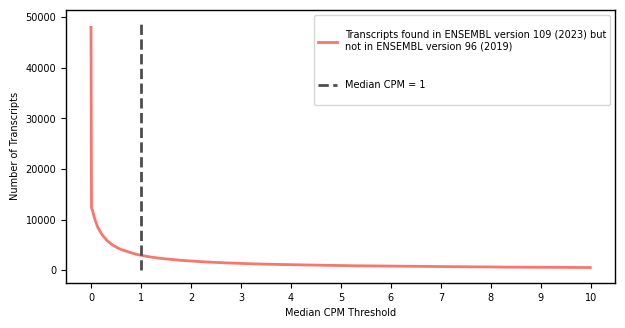

In [33]:
plt.plot(list_cpm_thresh, list_2023_all_transcript_median, color=ggplot2_colors[0], label="New transcripts since 2019", linewidth=2, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('Median CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.plot([1, 1], [-10, 49000], color="#4d4d4d", label="Median CPM = 1", linewidth=2, alpha=1, linestyle='dashed')
plt.legend(labels=["\nTranscripts found in ENSEMBL version 109 (2023) but\nnot in ENSEMBL version 96 (2019)\n", "\nMedian CPM = 1\n"], 
           loc="upper right", fontsize=7)

plt.savefig('../figures/new_transcripts_since_2019_across_cpm_threshold.pdf', dpi=600, transparent=True, bbox_inches="tight")

In [34]:
print("Number of new transcripts since 2019 with median CPM > 1 in our Nanopore sequenced brain samples:", list_2023_all_transcript_median[101])

Number of new transcripts since 2019 with median CPM > 1 in our Nanopore sequenced brain samples: 2932


In [35]:
df_exclusive_2023_transcripts_median = df_exclusive_2023_transcripts.loc[df_exclusive_2023_transcripts["median_CPM"] > 0].copy()

df_exclusive_2023_transcripts_median["Log10 median CPM"] = np.log10(df_exclusive_2023_transcripts_median["median_CPM"])

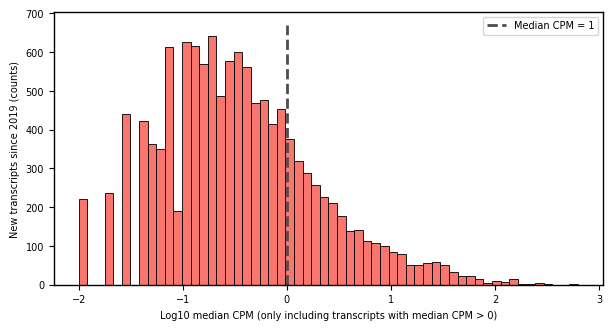

In [36]:
## Make average CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=df_exclusive_2023_transcripts_median["Log10 median CPM"], color=ggplot2_colors[0], alpha=1)

plt.plot([0, 0], [0, 670], color="#4d4d4d", label="Median CPM = 1", linewidth=2, alpha=1, linestyle='dashed')

plt.xlabel("Log10 median CPM (only including transcripts with median CPM > 0)")
plt.ylabel("New transcripts since 2019 (counts)")
plt.legend(fontsize=7)

plt.savefig('../figures/cpm_distribution_new_transcripts_since_2019.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [37]:
ensembl_2023_median_1 = df_exclusive_2023_transcripts.loc[df_exclusive_2023_transcripts["median_CPM"] > 1].copy()
ensembl_2023_new_cds_median_1 = df_exclusive_2023_ccds.loc[df_exclusive_2023_ccds["median_CPM"] > 1].copy()

ensembl_2023_med_relevant_median_1 = ensembl_2023_median_1.loc[ensembl_2023_median_1["gene_id"].isin(disease_relevant_genes["gene_id"])].copy()
ensembl_2023_med_relevant_new_cds_median_1 = ensembl_2023_med_relevant_median_1.loc[ensembl_2023_med_relevant_median_1["transcript_id"].isin(ensembl_2023_new_cds_median_1["transcript_id"])].copy()

ensembl_2023_brain_relevant_median_1 = ensembl_2023_median_1.loc[ensembl_2023_median_1["gene_id"].isin(brain_disease_gene_ids["gene_id"])].copy()
ensembl_2023_brain_relevant_new_cds_median_1 = ensembl_2023_brain_relevant_median_1.loc[ensembl_2023_brain_relevant_median_1["transcript_id"].isin(ensembl_2023_new_cds_median_1["transcript_id"])].copy()

In [38]:
df_barplot_2023 = pd.DataFrame()

df_barplot_2023["New Transcript Since 2019 (Median CPM > 1)"] = [ensembl_2023_med_relevant_median_1.shape[0], ensembl_2023_new_cds_median_1.shape[0],
                                                                ensembl_2023_med_relevant_new_cds_median_1.shape[0],
                                               ensembl_2023_brain_relevant_median_1.shape[0], ensembl_2023_brain_relevant_new_cds_median_1.shape[0]]

df_barplot_2023["Description"] = ["Med-relevant", "New protein coding sequence", "Med-relevant new protein coding sequence", 
                                "Brain disease relevant", "Brain disease relevant new protein coding sequence"]

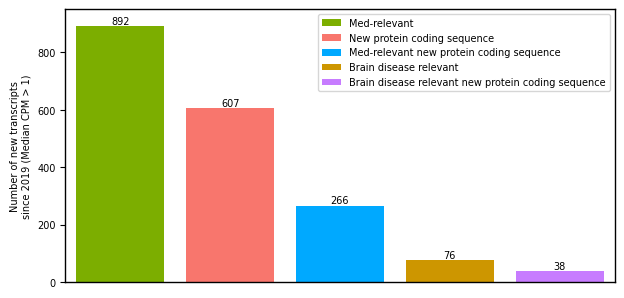

In [39]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=df_barplot_2023, y="New Transcript Since 2019 (Median CPM > 1)", x="Description", hue="Description",
            palette=[ggplot2_colors[2], ggplot2_colors[0], ggplot2_colors[5], ggplot2_colors[1], ggplot2_colors[6]], 
                 saturation=1, dodge=False, order=["Med-relevant", "New protein coding sequence", "Med-relevant new protein coding sequence", 
                                "Brain disease relevant", "Brain disease relevant new protein coding sequence"])
for container in ax.containers:
    ax.bar_label(container)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
    
ax.set(ylim=(0, 950))
plt.ylabel('Number of new transcripts\nsince 2019 (Median CPM > 1)')
ax.set(xticklabels=[], xlabel="")
ax.tick_params(bottom=False)
plt.legend(fontsize=7, loc="upper right")

plt.savefig('../figures/subcategories_number_of_new_transcripts_since_2019_expressed_in_brain.pdf', 
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [40]:
## Create dataframe to store percent expression
percent_expression_df = pd.DataFrame()

In [41]:
## Get percent expression from transcripts since 2019 for each subcategory
df_tmp = pd.DataFrame()


med_percent_expression = df.loc[df["gene_id"].isin(ensembl_2023_med_relevant_median_1["gene_id"])].copy()
med_relevant_relative_abundance = relative_transcript_abundance(med_percent_expression)

med_final_percent_expression = med_relevant_relative_abundance.loc[med_relevant_relative_abundance["transcript_id"].isin(ensembl_2023_med_relevant_median_1["transcript_id"])]
med_final_percent_expression = med_final_percent_expression.groupby('gene_id')['relative_abundance_percent'].sum().reset_index()
med_final_percent_expression = med_final_percent_expression.merge(gene_ref_2023[["gene_id", "gene_name"]], how="inner", on="gene_id")

df_tmp['Gene ID'] = med_final_percent_expression["gene_id"].copy()
df_tmp['Gene Name'] = med_final_percent_expression["gene_name"].copy()
df_tmp['Relative Abundance of New Transcripts Since 2019 (%)'] = med_final_percent_expression["relative_abundance_percent"].copy()
df_tmp["Category"] = "Med-relevant"

percent_expression_df = pd.concat([percent_expression_df, df_tmp])

In [42]:
## Get percent expression from transcripts since 2019 for each subcategory
df_tmp = pd.DataFrame()

cds_percent_expression = df.loc[df["gene_id"].isin(ensembl_2023_new_cds_median_1["gene_id"])].copy()
cds_relevant_relative_abundance = relative_transcript_abundance(cds_percent_expression)

cds_final_percent_expression = cds_relevant_relative_abundance.loc[cds_relevant_relative_abundance["transcript_id"].isin(ensembl_2023_new_cds_median_1["transcript_id"])]
cds_final_percent_expression = cds_final_percent_expression.groupby('gene_id')['relative_abundance_percent'].sum().reset_index()
cds_final_percent_expression = cds_final_percent_expression.merge(gene_ref_2023[["gene_id", "gene_name"]], how="inner", on="gene_id")

df_tmp['Gene ID'] = cds_final_percent_expression["gene_id"].copy()
df_tmp['Gene Name'] = cds_final_percent_expression["gene_name"].copy()
df_tmp['Relative Abundance of New Transcripts Since 2019 (%)'] = cds_final_percent_expression["relative_abundance_percent"].copy()
df_tmp["Category"] = "New protein coding sequence"

percent_expression_df = pd.concat([percent_expression_df, df_tmp])

In [43]:
## Get percent expression from transcripts since 2019 for each subcategory
df_tmp = pd.DataFrame()


med_cds_percent_expression = df.loc[df["gene_id"].isin(ensembl_2023_med_relevant_new_cds_median_1["gene_id"])].copy()
med_cds_relevant_relative_abundance = relative_transcript_abundance(med_cds_percent_expression)

med_cds_final_percent_expression = med_cds_relevant_relative_abundance.loc[med_cds_relevant_relative_abundance["transcript_id"].isin(ensembl_2023_med_relevant_new_cds_median_1["transcript_id"])]
med_cds_final_percent_expression = med_cds_final_percent_expression.groupby('gene_id')['relative_abundance_percent'].sum().reset_index()
med_cds_final_percent_expression = med_cds_final_percent_expression.merge(gene_ref_2023[["gene_id", "gene_name"]], how="inner", on="gene_id")

df_tmp['Gene ID'] = med_cds_final_percent_expression["gene_id"].copy()
df_tmp['Gene Name'] = med_cds_final_percent_expression["gene_name"].copy()
df_tmp['Relative Abundance of New Transcripts Since 2019 (%)'] = med_cds_final_percent_expression["relative_abundance_percent"].copy()
df_tmp["Category"] = "Med-relevant new protein coding sequence"

percent_expression_df = pd.concat([percent_expression_df, df_tmp])

In [44]:
## Get percent expression from transcripts since 2019 for each subcategory
df_tmp = pd.DataFrame()


brain_percent_expression = df.loc[df["gene_id"].isin(ensembl_2023_brain_relevant_median_1["gene_id"])].copy()
brain_relevant_relative_abundance = relative_transcript_abundance(brain_percent_expression)

brain_final_percent_expression = brain_relevant_relative_abundance.loc[brain_relevant_relative_abundance["transcript_id"].isin(ensembl_2023_brain_relevant_median_1["transcript_id"])]
brain_final_percent_expression = brain_final_percent_expression.groupby('gene_id')['relative_abundance_percent'].sum().reset_index()
brain_final_percent_expression = brain_final_percent_expression.merge(gene_ref_2023[["gene_id", "gene_name"]], how="inner", on="gene_id")

df_tmp['Gene ID'] = brain_final_percent_expression["gene_id"].copy()
df_tmp['Gene Name'] = brain_final_percent_expression["gene_name"].copy()
df_tmp['Relative Abundance of New Transcripts Since 2019 (%)'] = brain_final_percent_expression["relative_abundance_percent"].copy()
df_tmp["Category"] = "Brain disease relevant"

percent_expression_df = pd.concat([percent_expression_df, df_tmp])

In [45]:
## Get percent expression from transcripts since 2019 for each subcategory
df_tmp = pd.DataFrame()


brain_new_prot_percent_expression = df.loc[df["gene_id"].isin(ensembl_2023_brain_relevant_new_cds_median_1["gene_id"])].copy()
brain_new_prot_relevant_relative_abundance = relative_transcript_abundance(brain_new_prot_percent_expression)

brain_new_prot_final_percent_expression = brain_new_prot_relevant_relative_abundance.loc[brain_new_prot_relevant_relative_abundance["transcript_id"].isin(ensembl_2023_brain_relevant_new_cds_median_1["transcript_id"])]
brain_new_prot_final_percent_expression = brain_new_prot_final_percent_expression.groupby('gene_id')['relative_abundance_percent'].sum().reset_index()
brain_new_prot_final_percent_expression = brain_new_prot_final_percent_expression.merge(gene_ref_2023[["gene_id", "gene_name"]], how="inner", on="gene_id")

df_tmp['Gene ID'] = brain_new_prot_final_percent_expression["gene_id"].copy()
df_tmp['Gene Name'] = brain_new_prot_final_percent_expression["gene_name"].copy()
df_tmp['Relative Abundance of New Transcripts Since 2019 (%)'] = brain_new_prot_final_percent_expression["relative_abundance_percent"].copy()
df_tmp["Category"] = "Brain disease relevant new protein coding sequence"

percent_expression_df = pd.concat([percent_expression_df, df_tmp])

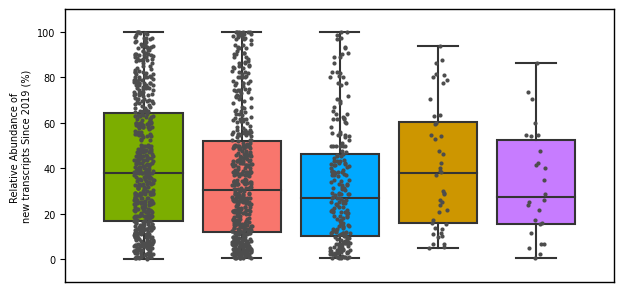

In [46]:
ax = sns.boxplot(data=percent_expression_df, y="Relative Abundance of New Transcripts Since 2019 (%)", x="Category", 
                 hue="Category",
            palette=[ggplot2_colors[2], ggplot2_colors[0], ggplot2_colors[5], ggplot2_colors[1], ggplot2_colors[6]], 
                 saturation=1, dodge=False, showfliers=False)

sns.stripplot(data=percent_expression_df, y="Relative Abundance of New Transcripts Since 2019 (%)", x="Category",
             color="#4d4d4d", size=3)


ax.set(ylim=(-10, 110))
ax.set(xlim=(-0.8, 4.8))
ax.set(xticklabels=[], ylabel="Relative Abundance of \nnew transcripts Since 2019 (%)", xlabel="")
ax.tick_params(bottom=False)

plt.legend([],[], frameon=False)

plt.savefig('../figures/subcategories_relative_abundance_of_new_transcripts_since_2019_expressed_in_brain.pdf',  
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [47]:
brain_disease_relevant_since_2019 = percent_expression_df.loc[percent_expression_df["Category"
                                                            ].str.contains("Brain disease relevant new")]

brain_disease_relevant_since_2019.columns = ["gene_id", "Gene Name", "Relative Abundance of New Transcripts Since 2019 (%)",
                                            "Category"]

brain_disease_relevant_since_2019 = brain_disease_relevant_since_2019.merge(
                                        brain_disease_annotations, on="gene_id", how="inner")

In [48]:
brain_relevant_new_cds_gene_list = ["ADAM17", "ABCA1", "GBF1", "ASXL3", "KIF5A", "VCP", "SHANK3", "SOX6", "CTNND1", "RHOA"]

brain_relevant_new_cds_examples = percent_expression_df.loc[percent_expression_df["Category"] == "Brain disease relevant new protein coding sequence"].copy()
brain_relevant_new_cds_examples = brain_relevant_new_cds_examples.loc[brain_relevant_new_cds_examples["Gene Name"].isin(brain_relevant_new_cds_gene_list)]

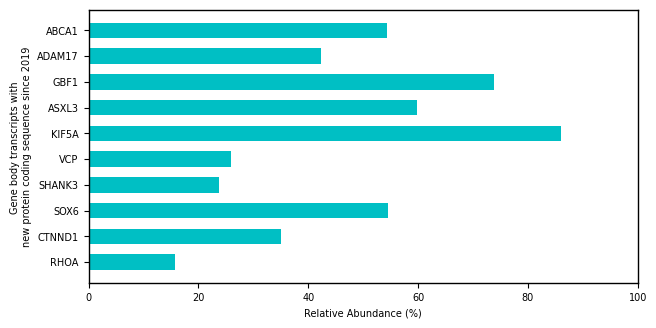

In [49]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=brain_relevant_new_cds_examples, y="Gene Name", x="Relative Abundance of New Transcripts Since 2019 (%)",
            palette=[ggplot2_colors[4]], saturation=1, 
            order=["ABCA1", "ADAM17", "GBF1", "ASXL3", "KIF5A", "VCP", "SHANK3", "SOX6", "CTNND1", "RHOA"],
            width=0.6)

ax.set(xlim=(0, 100))
plt.xlabel("Relative Abundance (%)")
plt.ylabel("Gene body transcripts with \nnew protein coding sequence since 2019")
ax.set_ylim(9.8, -0.8)


plt.savefig('../figures/poster_children_genes_expressed_in_brain_since_2019.pdf', 
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()